# Introduction

Body fat percentage is total mass of fat divided by total body mass, it is a important factor to show a person's health level, too high or too low will caused diseases. There are some body fat calculators online, however, there are too many variables. In this project, we try to find a simple, accurate and robust model to predict boday fat Percentage which obeys the 'Rule of Thumb'.

In [1]:
library(car)
library(leaps)
library(faraway)
library(glmnet)

Loading required package: carData


Registered S3 methods overwritten by 'lme4':
  method                          from
  cooks.distance.influence.merMod car 
  influence.merMod                car 
  dfbeta.influence.merMod         car 
  dfbetas.influence.merMod        car 



Attaching package: ‘faraway’



The following objects are masked from ‘package:car’:

    logit, vif



Loading required package: Matrix


Loading required package: foreach


Loaded glmnet 2.0-18



# Part 1: Dealing with raw data

#### Read in the raw data and do data cleaning (detect and delete the points which bodyfat does not have a linear relationship of 1 / density)

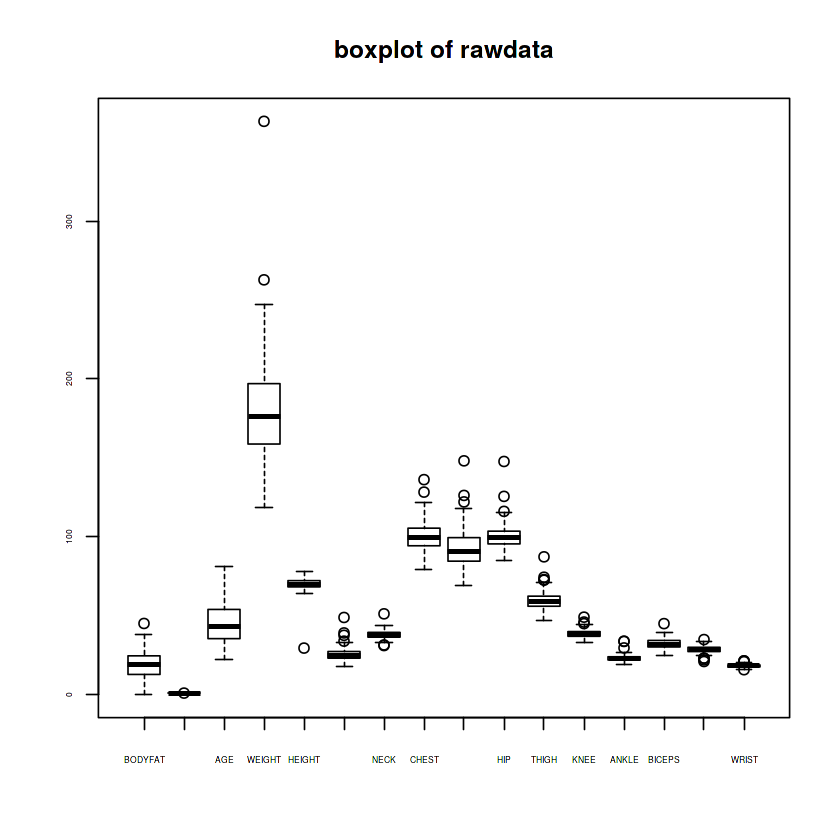

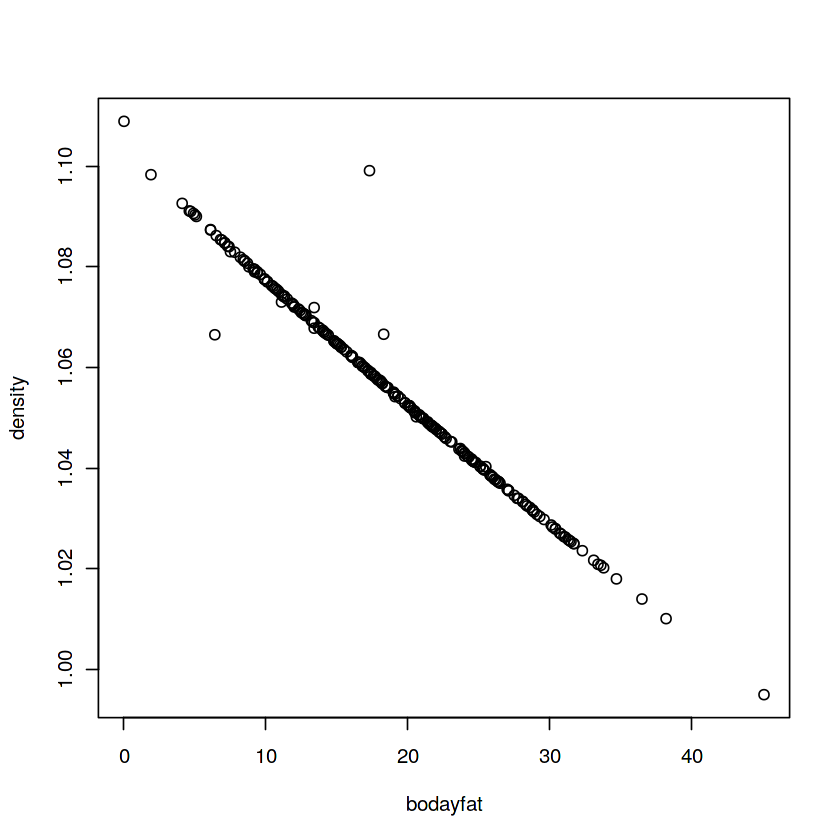

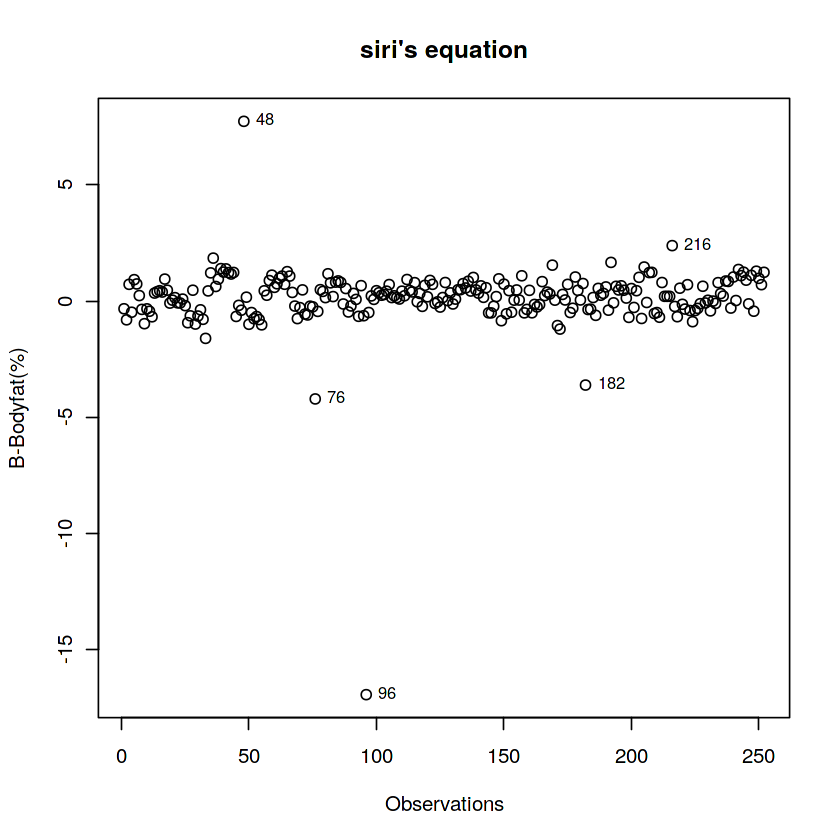

In [2]:
data = read.csv("BodyFat.csv", row.names = 1)
boxplot(data,main="boxplot of rawdata",cex.axis=0.4)     

plot(data$BODYFAT,data$DENSITY,xlab="bodayfat",ylab="density")
text(1:length(data[,1]), data$BODYFAT, 1:length(data[,1]),cex=0.5)
B = 495*(1/data$DENSITY)-450
plot(B-data$BODYFAT,xlab = 'Observations', ylab = 'B-Bodyfat(%)', main = "siri's equation")
text(c(48,76,96,182,216), B[c(48,76,96,182,216)]-data$BODYFAT[c(48,76,96,182,216)], c(48,76,96,182,216),cex=0.8,pos=4)

#### Continue data cleaning (detect and delete the points having wrong relationship of ADIPOSITY, WEIGHT and HEIGHT), then get rid of DENSITY

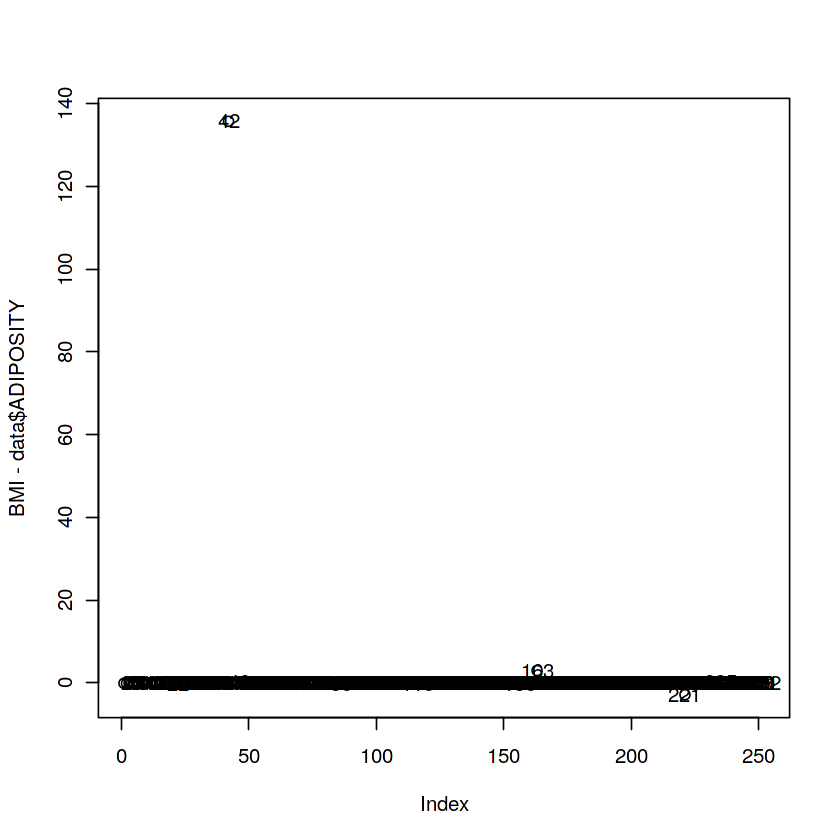

In [3]:
BMI=703*(data$WEIGHT/(data$HEIGHT)^2)
plot(BMI-data$ADIPOSITY)
text(1:length(data[,1]), BMI-data$ADIPOSITY, 1:length(data[,1]),cex=1)

# get rid of density and get a new dataset
data_new = data[, -2]

#### Then delete possible outliers:

,BODYFAT,DENSITY,AGE,WEIGHT,HEIGHT,ADIPOSITY,NECK,CHEST,ABDOMEN,HIP,THIGH,KNEE,ANKLE,BICEPS,FOREARM,WRIST
,<dbl>,<dbl>,<int>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
39,33.8,1.0202,46,363.15,72.25,48.9,51.2,136.2,148.1,147.7,87.3,49.1,29.6,45.0,29.0,21.4
42,31.7,1.0250,44,205.00,29.50,29.9,36.6,106.0,104.3,115.5,70.6,42.5,23.7,33.6,28.7,17.4
48,6.4,1.0665,39,148.50,71.25,20.6,34.6,89.8,79.5,92.7,52.7,37.5,21.9,28.8,26.8,17.9
96,17.3,1.0991,53,224.50,77.75,26.1,41.1,113.2,99.2,107.5,61.7,42.3,23.2,32.9,30.8,20.4
86,25.8,1.0386,67,167.00,67.50,26.0,36.5,98.9,89.7,96.2,54.7,37.8,33.7,32.4,27.7,18.2
76,18.3,1.0666,61,148.25,67.50,22.9,36.0,91.6,81.8,94.8,54.5,37.0,21.4,29.3,27.0,18.3
163,13.3,1.0690,33,184.25,68.75,24.4,40.7,98.9,92.1,103.5,64.0,37.3,23.5,33.5,30.6,19.7
182,0.0,1.1089,40,118.50,68.00,18.1,33.8,79.3,69.4,85.0,47.2,33.5,20.2,27.7,24.6,16.5
221,12.7,1.0706,54,153.25,70.50,24.5,38.5,99.0,91.8,96.2,57.7,38.1,23.9,31.4,29.9,18.9


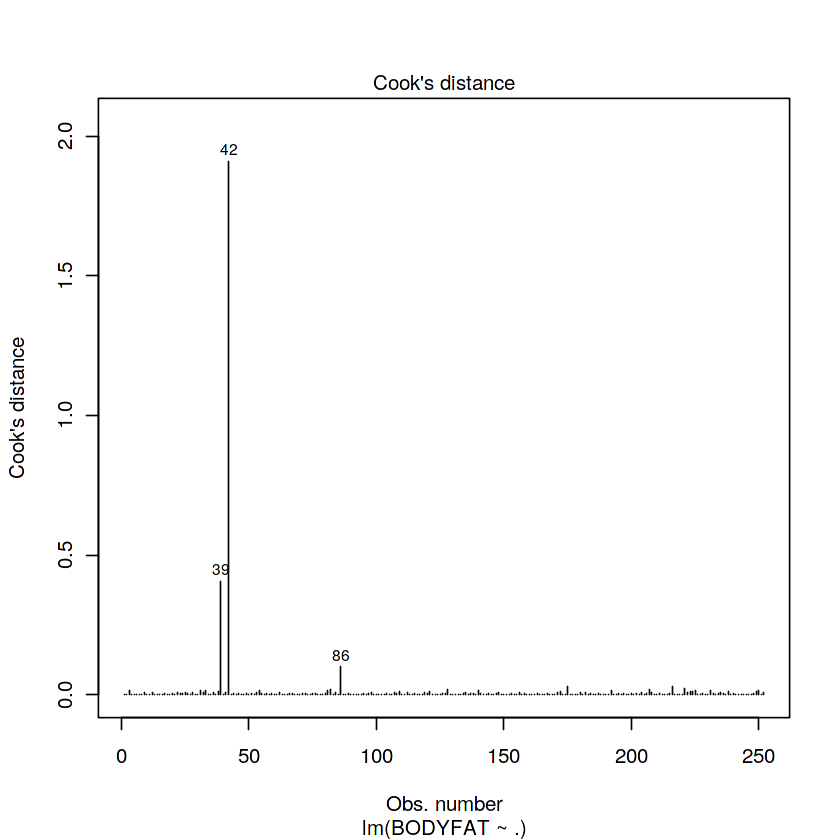

In [4]:
#check the cook's distance one by one
model1<- lm(BODYFAT ~ ., data = data_new)
plot(model1, which = 4)
#check the possible outliers
data[c(39, 42, 48, 96,86, 76, 163,182,221),]

#### No.39 has too large weight; No.42 is way too short.  
#### No.48,No.76,No.96 does not match the relationship between bodyfat and density.
#### No.182 has bodyfat 0, it is a mistake.
#### No.221,No.163 don't obey the BMI equation (also No.42).
#### We remove them and scale the data to get a new dataset. Then check the Cook's distance again.

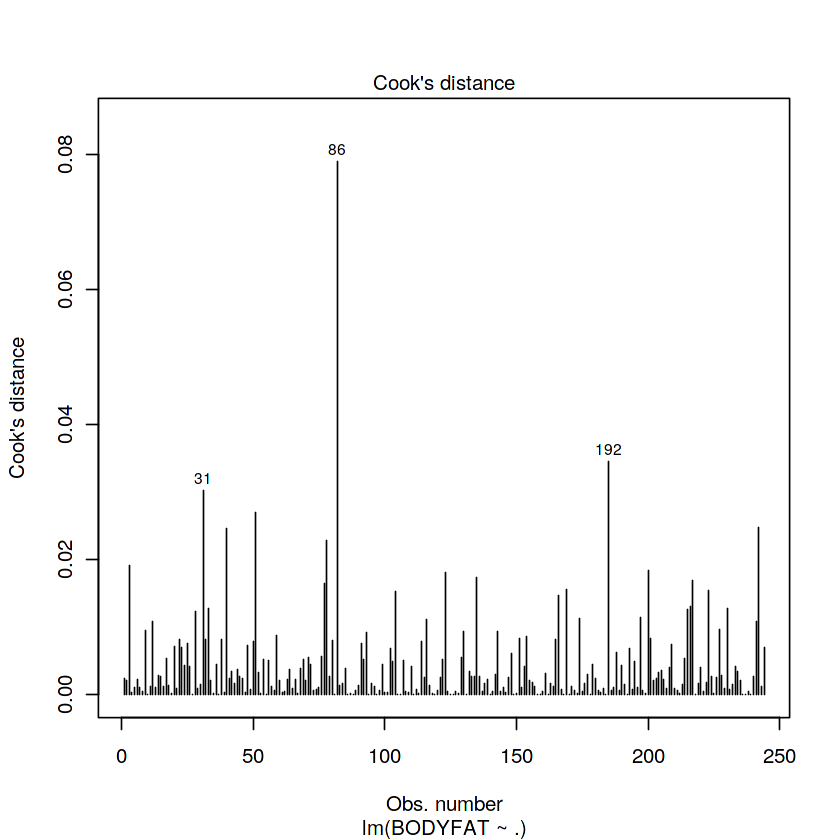

In [5]:
data_clean = data_new[c(-39,-42, -48, -96, -76, -163, -182, -221), ]
data_clean<-data.frame(scale(data_clean))#scale the data
write.csv(data_clean,"bodyfat_clean.csv",row.names = F)

#check the cook's distance again
model = lm(BODYFAT ~ ., data = data_clean)
plot(model, which = 4)

#### We check new data's Cook's distance again and find nothing weird. 

# Part 2: Model selection

#### The methods we use are: AIC, BIC, Mallow's Cp, Adjusted-R^2 and lasso.

In [6]:
full = lm(BODYFAT ~ ., data = data_clean)
base = lm(BODYFAT ~ 1, data = data_clean)

#### 1. AIC (Backward, forward and both sides)

In [7]:
model_AIC_b = step(full, direction = "backward", trace = 0)
print(model_AIC_b)
summary(model_AIC_b)

model_AIC_f = step(base, direction = "forward", trace = 0,scope = list(lower = base, upper = full))
print(model_AIC_f)

model_AIC_t = step(base, direction = "both", trace = 0, scope = list(lower = base, upper = full))
print(model_AIC_t)


Call:
lm(formula = BODYFAT ~ AGE + WEIGHT + HEIGHT + ADIPOSITY + NECK + 
    ABDOMEN + HIP + THIGH + FOREARM + WRIST, data = data_clean)

Coefficients:
(Intercept)          AGE       WEIGHT       HEIGHT    ADIPOSITY         NECK  
  1.413e-15    9.644e-02   -1.021e+00    3.811e-01    7.602e-01   -9.918e-02  
    ABDOMEN          HIP        THIGH      FOREARM        WRIST  
  1.076e+00   -1.642e-01    1.701e-01    8.393e-02   -1.678e-01  




Call:
lm(formula = BODYFAT ~ AGE + WEIGHT + HEIGHT + ADIPOSITY + NECK + 
    ABDOMEN + HIP + THIGH + FOREARM + WRIST, data = data_clean)

Residuals:
     Min       1Q   Median       3Q      Max 
-1.25248 -0.35972 -0.03786  0.36854  1.20348 

Coefficients:
              Estimate Std. Error t value Pr(>|t|)    
(Intercept)  1.413e-15  3.276e-02   0.000  1.00000    
AGE          9.644e-02  4.809e-02   2.005  0.04608 *  
WEIGHT      -1.021e+00  4.902e-01  -2.083  0.03831 *  
HEIGHT       3.811e-01  2.435e-01   1.565  0.11896    
ADIPOSITY    7.602e-01  4.288e-01   1.773  0.07755 .  
NECK        -9.918e-02  6.358e-02  -1.560  0.12017    
ABDOMEN      1.076e+00  1.111e-01   9.684  < 2e-16 ***
HIP         -1.642e-01  1.133e-01  -1.449  0.14879    
THIGH        1.701e-01  7.905e-02   2.152  0.03241 *  
FOREARM      8.393e-02  4.880e-02   1.720  0.08680 .  
WRIST       -1.678e-01  5.704e-02  -2.942  0.00359 ** 
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Residual standa


Call:
lm(formula = BODYFAT ~ ABDOMEN + WEIGHT + WRIST + BICEPS, data = data_clean)

Coefficients:
(Intercept)      ABDOMEN       WEIGHT        WRIST       BICEPS  
  2.369e-16    1.204e+00   -4.139e-01   -1.477e-01    1.077e-01  




Call:
lm(formula = BODYFAT ~ ABDOMEN + WEIGHT + WRIST + BICEPS, data = data_clean)

Coefficients:
(Intercept)      ABDOMEN       WEIGHT        WRIST       BICEPS  
  2.369e-16    1.204e+00   -4.139e-01   -1.477e-01    1.077e-01  



#### 2. BIC (Backward, forward and both sides)

In [8]:
n = dim(data_clean)[1]
model_BIC_b = step(full, direction = "backward", trace = 0, k = log(n))
print(model_BIC_b)
summary(model_BIC_b)

model_BIC_f = step(base, direction = "forward", trace = 0, scope = list(lower = base, upper = full), k = log(n))
print(model_BIC_f )

model_BIC_t = step(full, direction = "both", trace = 0, k = log(n))
print(model_BIC_t)
summary(model_BIC_t)


Call:
lm(formula = BODYFAT ~ WEIGHT + ABDOMEN + WRIST, data = data_clean)

Coefficients:
(Intercept)       WEIGHT      ABDOMEN        WRIST  
  1.574e-16   -3.238e-01    1.189e+00   -1.376e-01  




Call:
lm(formula = BODYFAT ~ WEIGHT + ABDOMEN + WRIST, data = data_clean)

Residuals:
     Min       1Q   Median       3Q      Max 
-1.18875 -0.37533 -0.03202  0.38206  1.20597 

Coefficients:
              Estimate Std. Error t value Pr(>|t|)    
(Intercept)  1.574e-16  3.329e-02   0.000  1.00000    
WEIGHT      -3.238e-01  7.969e-02  -4.063 6.58e-05 ***
ABDOMEN      1.189e+00  6.861e-02  17.329  < 2e-16 ***
WRIST       -1.376e-01  4.878e-02  -2.821  0.00519 ** 
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Residual standard error: 0.5199 on 240 degrees of freedom
Multiple R-squared:  0.733,	Adjusted R-squared:  0.7297 
F-statistic: 219.6 on 3 and 240 DF,  p-value: < 2.2e-16



Call:
lm(formula = BODYFAT ~ ABDOMEN + WEIGHT + WRIST, data = data_clean)

Coefficients:
(Intercept)      ABDOMEN       WEIGHT        WRIST  
  1.574e-16    1.189e+00   -3.238e-01   -1.376e-01  




Call:
lm(formula = BODYFAT ~ WEIGHT + ABDOMEN + WRIST, data = data_clean)

Coefficients:
(Intercept)       WEIGHT      ABDOMEN        WRIST  
  1.574e-16   -3.238e-01    1.189e+00   -1.376e-01  




Call:
lm(formula = BODYFAT ~ WEIGHT + ABDOMEN + WRIST, data = data_clean)

Residuals:
     Min       1Q   Median       3Q      Max 
-1.18875 -0.37533 -0.03202  0.38206  1.20597 

Coefficients:
              Estimate Std. Error t value Pr(>|t|)    
(Intercept)  1.574e-16  3.329e-02   0.000  1.00000    
WEIGHT      -3.238e-01  7.969e-02  -4.063 6.58e-05 ***
ABDOMEN      1.189e+00  6.861e-02  17.329  < 2e-16 ***
WRIST       -1.376e-01  4.878e-02  -2.821  0.00519 ** 
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Residual standard error: 0.5199 on 240 degrees of freedom
Multiple R-squared:  0.733,	Adjusted R-squared:  0.7297 
F-statistic: 219.6 on 3 and 240 DF,  p-value: < 2.2e-16


#### 3. Mallow's cp

 [1] "AGE"       "WEIGHT"    "HEIGHT"    "ADIPOSITY" "NECK"      "ABDOMEN"  
 [7] "HIP"       "THIGH"     "FOREARM"   "WRIST"    



Call:
lm(formula = cp_model, data = data_clean)

Residuals:
     Min       1Q   Median       3Q      Max 
-1.25248 -0.35972 -0.03786  0.36854  1.20348 

Coefficients:
              Estimate Std. Error t value Pr(>|t|)    
(Intercept)  1.413e-15  3.276e-02   0.000  1.00000    
AGE          9.644e-02  4.809e-02   2.005  0.04608 *  
WEIGHT      -1.021e+00  4.902e-01  -2.083  0.03831 *  
HEIGHT       3.811e-01  2.435e-01   1.565  0.11896    
ADIPOSITY    7.602e-01  4.288e-01   1.773  0.07755 .  
NECK        -9.918e-02  6.358e-02  -1.560  0.12017    
ABDOMEN      1.076e+00  1.111e-01   9.684  < 2e-16 ***
HIP         -1.642e-01  1.133e-01  -1.449  0.14879    
THIGH        1.701e-01  7.905e-02   2.152  0.03241 *  
FOREARM      8.393e-02  4.880e-02   1.720  0.08680 .  
WRIST       -1.678e-01  5.704e-02  -2.942  0.00359 ** 
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Residual standard error: 0.5117 on 233 degrees of freedom
Multiple R-squared:  0.7489,	Adjusted R-square

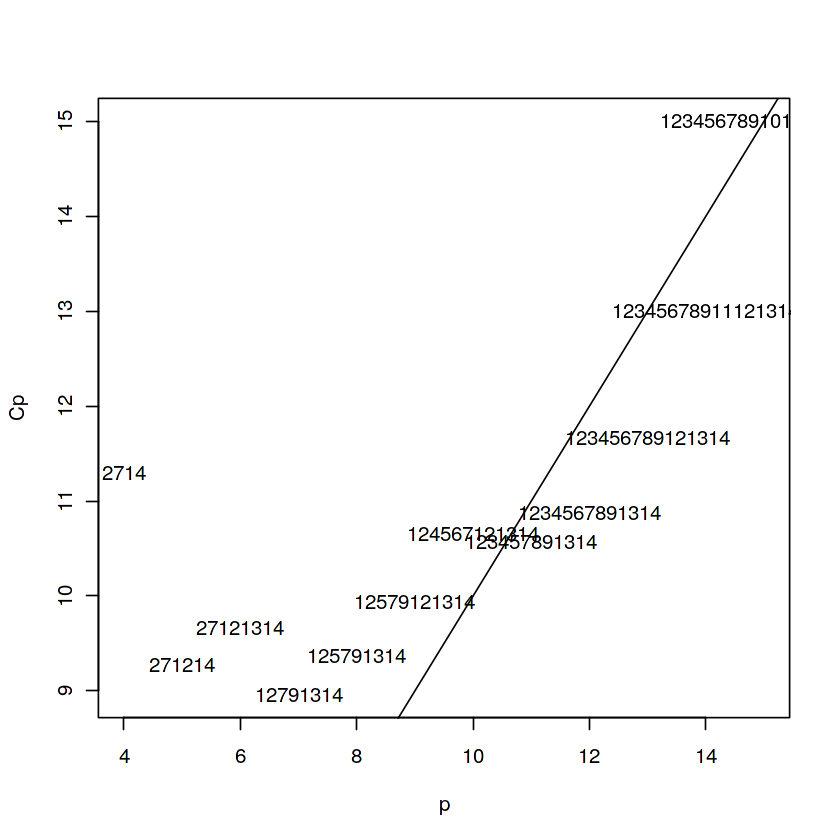

In [9]:
X = data_clean[, -1]
Y = data_clean$BODYFAT
g = leaps(X, Y, nbest = 1)
Cpplot(g)
print(colnames(data_clean)[c(1, 2, 3, 4, 5, 7,8,9,13,14) + 1])
cp_model = BODYFAT ~ AGE +WEIGHT+ HEIGHT +ADIPOSITY+NECK+ ABDOMEN +HIP+ THIGH +FOREARM + WRIST
cp_lm = lm(cp_model, data=data_clean)
summary(cp_lm)

#### 4. Adjusted R square

1     2     3     4     5     6     7     8     9     A     B     C     D 
 TRUE  TRUE  TRUE  TRUE  TRUE  TRUE  TRUE  TRUE  TRUE FALSE FALSE  TRUE  TRUE 
    E 
 TRUE

 [1] "AGE"       "WEIGHT"    "HEIGHT"    "ADIPOSITY" "NECK"      "CHEST"    
 [7] "ABDOMEN"   "HIP"       "THIGH"     "BICEPS"    "FOREARM"   "WRIST"    



Call:
lm(formula = Ad_r, data = data_clean)

Coefficients:
(Intercept)          AGE       WEIGHT       HEIGHT    ADIPOSITY         NECK  
  1.451e-15    9.742e-02   -9.867e-01    3.979e-01    8.468e-01   -1.014e-01  
      CHEST      ABDOMEN          HIP        THIGH       BICEPS      FOREARM  
 -1.483e-01    1.123e+00   -1.831e-01    1.208e-01    6.640e-02    6.720e-02  
      WRIST  
 -1.780e-01  



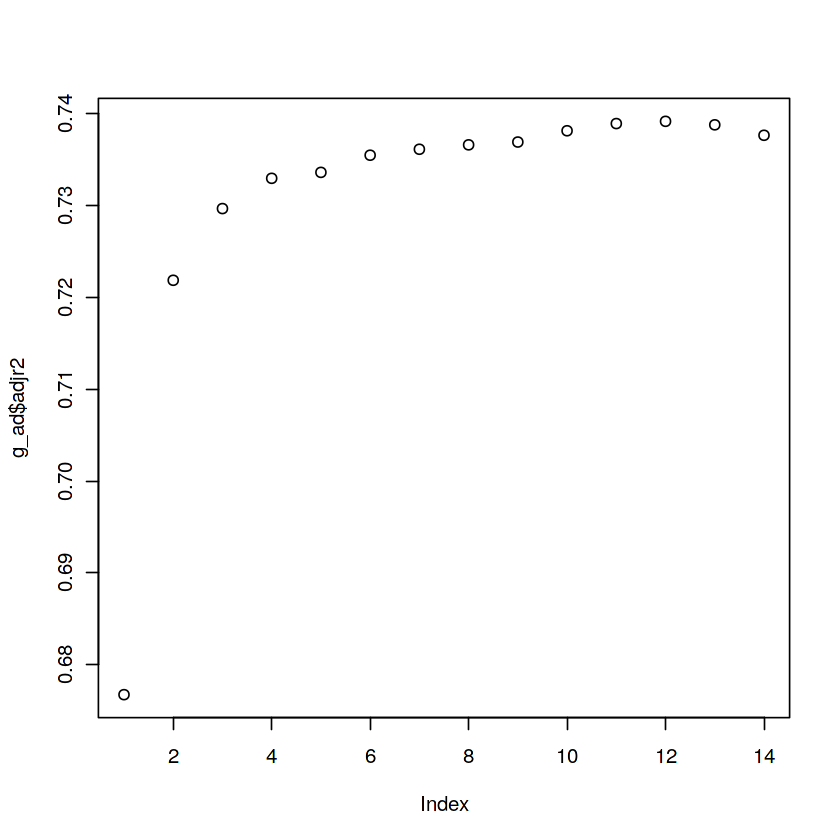

In [10]:
g_ad = leaps(X, Y, nbest = 1,method="adjr2")
plot(g_ad$adjr2)
(g_ad$which)[which(g_ad$adjr2==max(g_ad$adjr2)),]
print(colnames(data_clean)[c(1:9, 12:14) + 1])
Ad_r=BODYFAT~AGE +WEIGHT+ HEIGHT +ADIPOSITY+NECK+CHEST+ ABDOMEN +HIP+ THIGH +BICEPS+FOREARM + WRIST
adr_model<-lm(Ad_r,data=data_clean)
print(adr_model)

#### 5. Lasso


Call:  glmnet(x = as.matrix(data_clean[, 2:15]), y = data_clean$BODYFAT,      family = "gaussian", alpha = 1, nlambda = 50, standardize = T) 

      Df   %Dev    Lambda
 [1,]  0 0.0000 0.8218000
 [2,]  1 0.2125 0.6809000
 [3,]  1 0.3584 0.5643000
 [4,]  1 0.4586 0.4676000
 [5,]  1 0.5273 0.3875000
 [6,]  1 0.5746 0.3211000
 [7,]  1 0.6070 0.2660000
 [8,]  1 0.6293 0.2205000
 [9,]  1 0.6446 0.1827000
[10,]  2 0.6557 0.1514000
[11,]  2 0.6732 0.1254000
[12,]  2 0.6852 0.1039000
[13,]  3 0.6936 0.0861300
[14,]  4 0.7041 0.0713700
[15,]  4 0.7137 0.0591400
[16,]  4 0.7203 0.0490100
[17,]  4 0.7249 0.0406100
[18,]  4 0.7280 0.0336500
[19,]  5 0.7303 0.0278800
[20,]  5 0.7324 0.0231100
[21,]  7 0.7346 0.0191500
[22,]  7 0.7366 0.0158700
[23,]  9 0.7384 0.0131500
[24,] 10 0.7405 0.0108900
[25,] 11 0.7427 0.0090270
[26,] 11 0.7445 0.0074810
[27,] 11 0.7457 0.0061990
[28,] 12 0.7467 0.0051360
[29,] 13 0.7474 0.0042560
[30,] 13 0.7479 0.0035270
[31,] 14 0.7483 0.0029230
[32,] 14 0.7493 0.002422

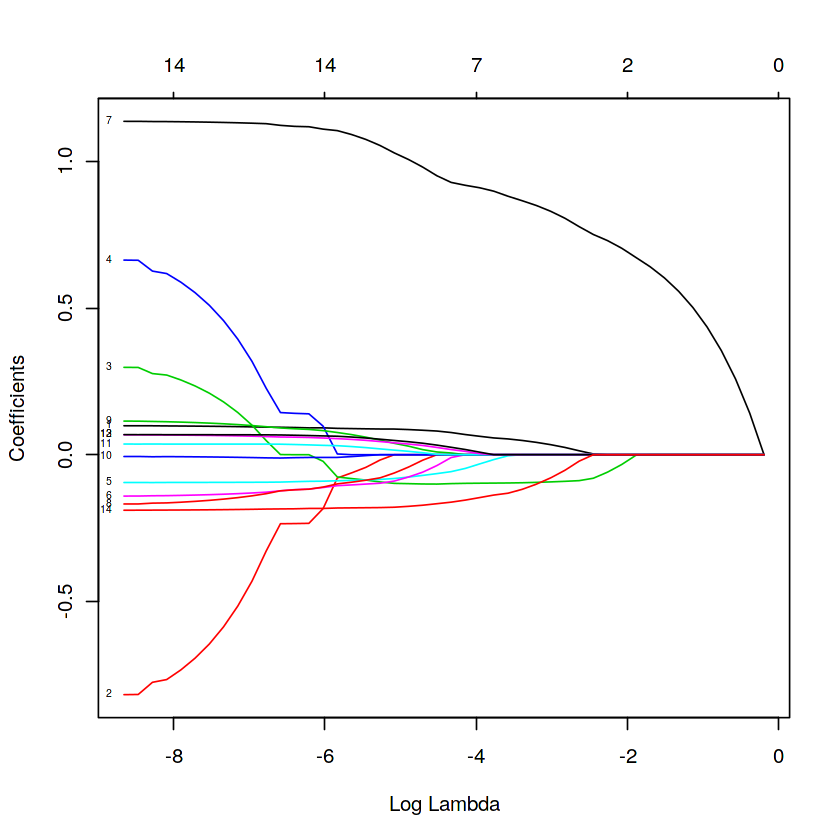

15 x 1 sparse Matrix of class "dgCMatrix"
                        1
(Intercept) -1.056100e-16
AGE          1.174299e-02
WEIGHT       .           
HEIGHT      -8.806614e-02
ADIPOSITY    .           
NECK         .           
CHEST        .           
ABDOMEN      7.732062e-01
HIP          .           
THIGH        .           
KNEE         .           
ANKLE        .           
BICEPS       .           
FOREARM      .           
WRIST       -1.752753e-02



Call:
lm(formula = BODYFAT ~ AGE + HEIGHT + ABDOMEN + WRIST, data = data_clean)

Coefficients:
(Intercept)          AGE       HEIGHT      ABDOMEN        WRIST  
 -3.209e-16    7.994e-02   -1.020e-01    9.444e-01   -2.036e-01  



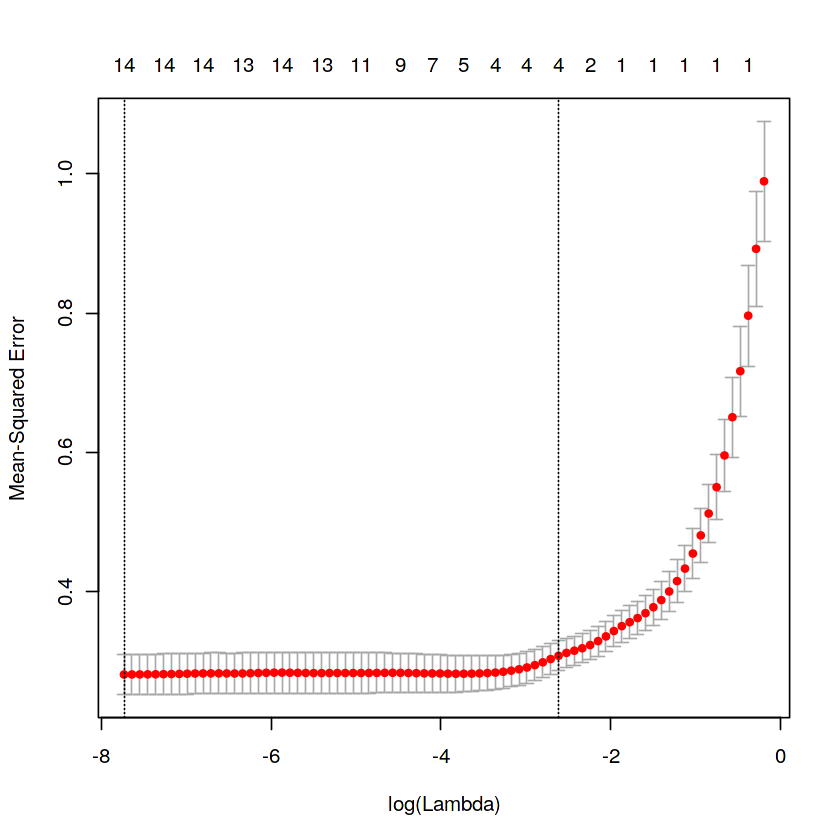

In [11]:
model_l <- glmnet(as.matrix(data_clean[,2:15]), data_clean$BODYFAT, family = "gaussian", nlambda = 50, alpha = 1,standardize = T)
print(model_l)
plot(model_l, xvar = "lambda", label = T)
cvfit <- cv.glmnet(as.matrix(data_clean[,2:15]), data_clean$BODYFAT, family = "gaussian", type.measure = "mse", nfolds = 10,alpha = 1)
plot(cvfit)
print(coef(cvfit, s = "lambda.1se" ))
model_lasso<- BODYFAT ~ AGE + HEIGHT  + ABDOMEN +  WRIST
model_l<-lm(BODYFAT ~ AGE + HEIGHT  + ABDOMEN +  WRIST,data=data_clean)
print(model_l)

# Part3: Other analysis

#### We compare the models above by their summary table and plots.

In [12]:
summary(model_AIC_b)
summary(model_AIC_f)
summary(model_AIC_t)


summary(model_BIC_b)
summary(model_BIC_f)
summary(model_BIC_t)

summary(cp_lm)
summary(adr_model)
summary(model_l)


Call:
lm(formula = BODYFAT ~ AGE + WEIGHT + HEIGHT + ADIPOSITY + NECK + 
    ABDOMEN + HIP + THIGH + FOREARM + WRIST, data = data_clean)

Residuals:
     Min       1Q   Median       3Q      Max 
-1.25248 -0.35972 -0.03786  0.36854  1.20348 

Coefficients:
              Estimate Std. Error t value Pr(>|t|)    
(Intercept)  1.413e-15  3.276e-02   0.000  1.00000    
AGE          9.644e-02  4.809e-02   2.005  0.04608 *  
WEIGHT      -1.021e+00  4.902e-01  -2.083  0.03831 *  
HEIGHT       3.811e-01  2.435e-01   1.565  0.11896    
ADIPOSITY    7.602e-01  4.288e-01   1.773  0.07755 .  
NECK        -9.918e-02  6.358e-02  -1.560  0.12017    
ABDOMEN      1.076e+00  1.111e-01   9.684  < 2e-16 ***
HIP         -1.642e-01  1.133e-01  -1.449  0.14879    
THIGH        1.701e-01  7.905e-02   2.152  0.03241 *  
FOREARM      8.393e-02  4.880e-02   1.720  0.08680 .  
WRIST       -1.678e-01  5.704e-02  -2.942  0.00359 ** 
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Residual standa


Call:
lm(formula = BODYFAT ~ ABDOMEN + WEIGHT + WRIST + BICEPS, data = data_clean)

Residuals:
     Min       1Q   Median       3Q      Max 
-1.23562 -0.36528 -0.01922  0.39216  1.12071 

Coefficients:
              Estimate Std. Error t value Pr(>|t|)    
(Intercept)  2.369e-16  3.308e-02   0.000  1.00000    
ABDOMEN      1.204e+00  6.860e-02  17.549  < 2e-16 ***
WEIGHT      -4.139e-01  9.123e-02  -4.536 9.07e-06 ***
WRIST       -1.477e-01  4.875e-02  -3.029  0.00272 ** 
BICEPS       1.077e-01  5.412e-02   1.990  0.04774 *  
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Residual standard error: 0.5168 on 239 degrees of freedom
Multiple R-squared:  0.7373,	Adjusted R-squared:  0.7329 
F-statistic: 167.7 on 4 and 239 DF,  p-value: < 2.2e-16



Call:
lm(formula = BODYFAT ~ ABDOMEN + WEIGHT + WRIST + BICEPS, data = data_clean)

Residuals:
     Min       1Q   Median       3Q      Max 
-1.23562 -0.36528 -0.01922  0.39216  1.12071 

Coefficients:
              Estimate Std. Error t value Pr(>|t|)    
(Intercept)  2.369e-16  3.308e-02   0.000  1.00000    
ABDOMEN      1.204e+00  6.860e-02  17.549  < 2e-16 ***
WEIGHT      -4.139e-01  9.123e-02  -4.536 9.07e-06 ***
WRIST       -1.477e-01  4.875e-02  -3.029  0.00272 ** 
BICEPS       1.077e-01  5.412e-02   1.990  0.04774 *  
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Residual standard error: 0.5168 on 239 degrees of freedom
Multiple R-squared:  0.7373,	Adjusted R-squared:  0.7329 
F-statistic: 167.7 on 4 and 239 DF,  p-value: < 2.2e-16



Call:
lm(formula = BODYFAT ~ WEIGHT + ABDOMEN + WRIST, data = data_clean)

Residuals:
     Min       1Q   Median       3Q      Max 
-1.18875 -0.37533 -0.03202  0.38206  1.20597 

Coefficients:
              Estimate Std. Error t value Pr(>|t|)    
(Intercept)  1.574e-16  3.329e-02   0.000  1.00000    
WEIGHT      -3.238e-01  7.969e-02  -4.063 6.58e-05 ***
ABDOMEN      1.189e+00  6.861e-02  17.329  < 2e-16 ***
WRIST       -1.376e-01  4.878e-02  -2.821  0.00519 ** 
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Residual standard error: 0.5199 on 240 degrees of freedom
Multiple R-squared:  0.733,	Adjusted R-squared:  0.7297 
F-statistic: 219.6 on 3 and 240 DF,  p-value: < 2.2e-16



Call:
lm(formula = BODYFAT ~ ABDOMEN + WEIGHT + WRIST, data = data_clean)

Residuals:
     Min       1Q   Median       3Q      Max 
-1.18875 -0.37533 -0.03202  0.38206  1.20597 

Coefficients:
              Estimate Std. Error t value Pr(>|t|)    
(Intercept)  1.574e-16  3.329e-02   0.000  1.00000    
ABDOMEN      1.189e+00  6.861e-02  17.329  < 2e-16 ***
WEIGHT      -3.238e-01  7.969e-02  -4.063 6.58e-05 ***
WRIST       -1.376e-01  4.878e-02  -2.821  0.00519 ** 
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Residual standard error: 0.5199 on 240 degrees of freedom
Multiple R-squared:  0.733,	Adjusted R-squared:  0.7297 
F-statistic: 219.6 on 3 and 240 DF,  p-value: < 2.2e-16



Call:
lm(formula = BODYFAT ~ WEIGHT + ABDOMEN + WRIST, data = data_clean)

Residuals:
     Min       1Q   Median       3Q      Max 
-1.18875 -0.37533 -0.03202  0.38206  1.20597 

Coefficients:
              Estimate Std. Error t value Pr(>|t|)    
(Intercept)  1.574e-16  3.329e-02   0.000  1.00000    
WEIGHT      -3.238e-01  7.969e-02  -4.063 6.58e-05 ***
ABDOMEN      1.189e+00  6.861e-02  17.329  < 2e-16 ***
WRIST       -1.376e-01  4.878e-02  -2.821  0.00519 ** 
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Residual standard error: 0.5199 on 240 degrees of freedom
Multiple R-squared:  0.733,	Adjusted R-squared:  0.7297 
F-statistic: 219.6 on 3 and 240 DF,  p-value: < 2.2e-16



Call:
lm(formula = cp_model, data = data_clean)

Residuals:
     Min       1Q   Median       3Q      Max 
-1.25248 -0.35972 -0.03786  0.36854  1.20348 

Coefficients:
              Estimate Std. Error t value Pr(>|t|)    
(Intercept)  1.413e-15  3.276e-02   0.000  1.00000    
AGE          9.644e-02  4.809e-02   2.005  0.04608 *  
WEIGHT      -1.021e+00  4.902e-01  -2.083  0.03831 *  
HEIGHT       3.811e-01  2.435e-01   1.565  0.11896    
ADIPOSITY    7.602e-01  4.288e-01   1.773  0.07755 .  
NECK        -9.918e-02  6.358e-02  -1.560  0.12017    
ABDOMEN      1.076e+00  1.111e-01   9.684  < 2e-16 ***
HIP         -1.642e-01  1.133e-01  -1.449  0.14879    
THIGH        1.701e-01  7.905e-02   2.152  0.03241 *  
FOREARM      8.393e-02  4.880e-02   1.720  0.08680 .  
WRIST       -1.678e-01  5.704e-02  -2.942  0.00359 ** 
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Residual standard error: 0.5117 on 233 degrees of freedom
Multiple R-squared:  0.7489,	Adjusted R-square


Call:
lm(formula = Ad_r, data = data_clean)

Residuals:
     Min       1Q   Median       3Q      Max 
-1.24761 -0.34427 -0.02745  0.37215  1.16835 

Coefficients:
              Estimate Std. Error t value Pr(>|t|)    
(Intercept)  1.451e-15  3.270e-02   0.000  1.00000    
AGE          9.742e-02  4.824e-02   2.019  0.04460 *  
WEIGHT      -9.867e-01  4.954e-01  -1.992  0.04757 *  
HEIGHT       3.979e-01  2.433e-01   1.635  0.10338    
ADIPOSITY    8.468e-01  4.323e-01   1.959  0.05134 .  
NECK        -1.014e-01  6.367e-02  -1.592  0.11273    
CHEST       -1.483e-01  1.086e-01  -1.365  0.17357    
ABDOMEN      1.123e+00  1.143e-01   9.825  < 2e-16 ***
HIP         -1.831e-01  1.155e-01  -1.585  0.11440    
THIGH        1.208e-01  8.401e-02   1.438  0.15169    
BICEPS       6.640e-02  6.020e-02   1.103  0.27115    
FOREARM      6.720e-02  5.070e-02   1.326  0.18631    
WRIST       -1.780e-01  5.731e-02  -3.107  0.00213 ** 
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1


Call:
lm(formula = BODYFAT ~ AGE + HEIGHT + ABDOMEN + WRIST, data = data_clean)

Residuals:
     Min       1Q   Median       3Q      Max 
-1.25508 -0.37499 -0.03633  0.39655  1.14166 

Coefficients:
              Estimate Std. Error t value Pr(>|t|)    
(Intercept) -3.209e-16  3.324e-02   0.000  1.00000    
AGE          7.994e-02  3.722e-02   2.148  0.03272 *  
HEIGHT      -1.020e-01  3.905e-02  -2.612  0.00958 ** 
ABDOMEN      9.444e-01  4.223e-02  22.361  < 2e-16 ***
WRIST       -2.036e-01  4.591e-02  -4.434 1.41e-05 ***
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Residual standard error: 0.5193 on 239 degrees of freedom
Multiple R-squared:  0.7348,	Adjusted R-squared:  0.7304 
F-statistic: 165.5 on 4 and 239 DF,  p-value: < 2.2e-16


## Diagnostic plot

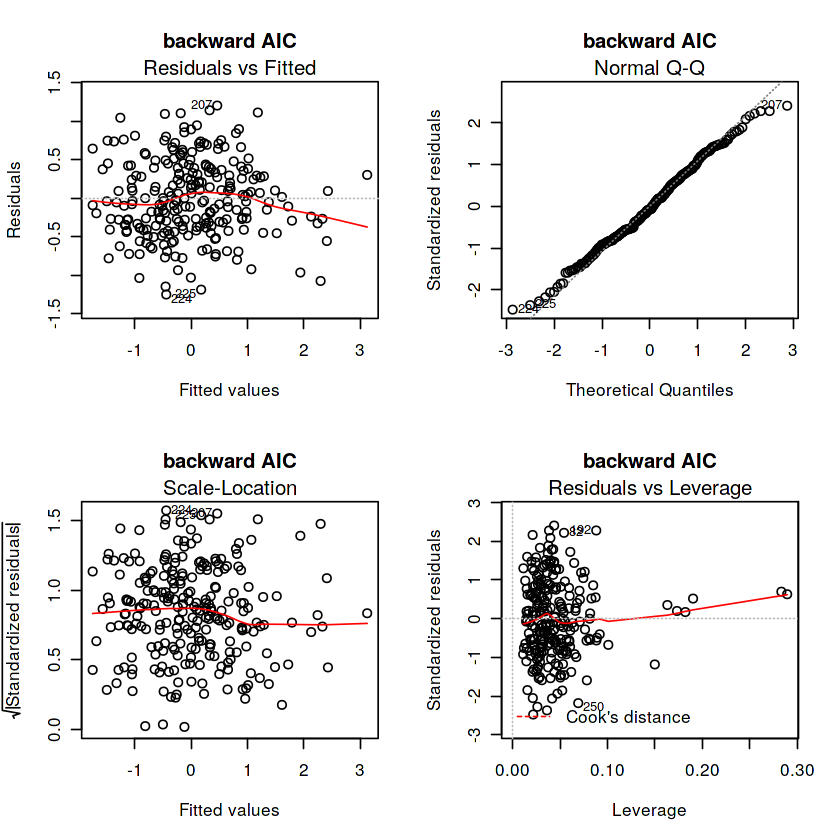

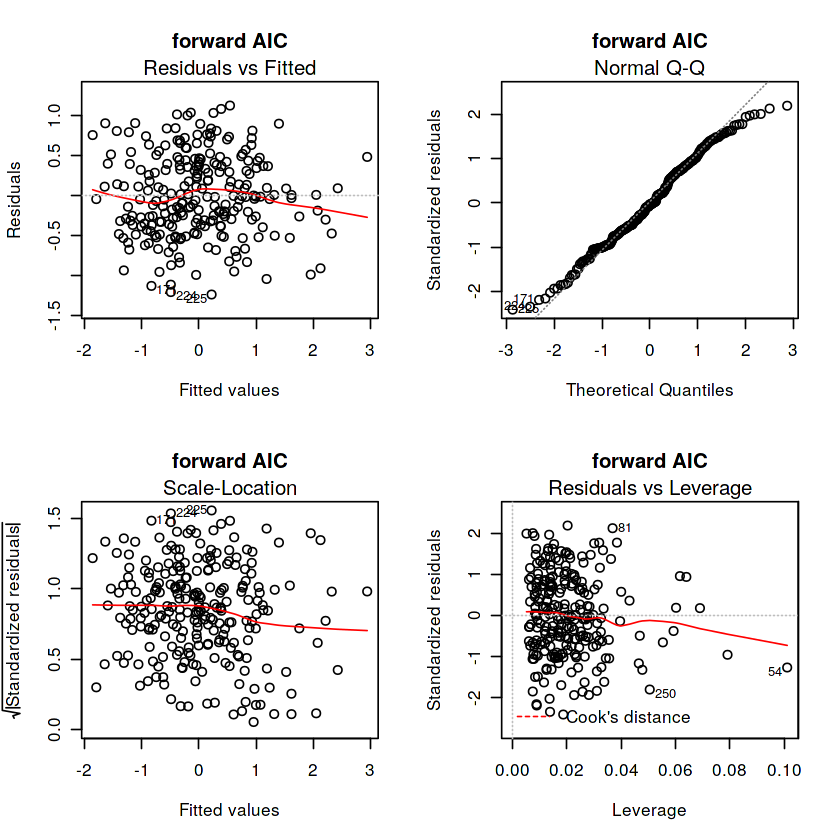

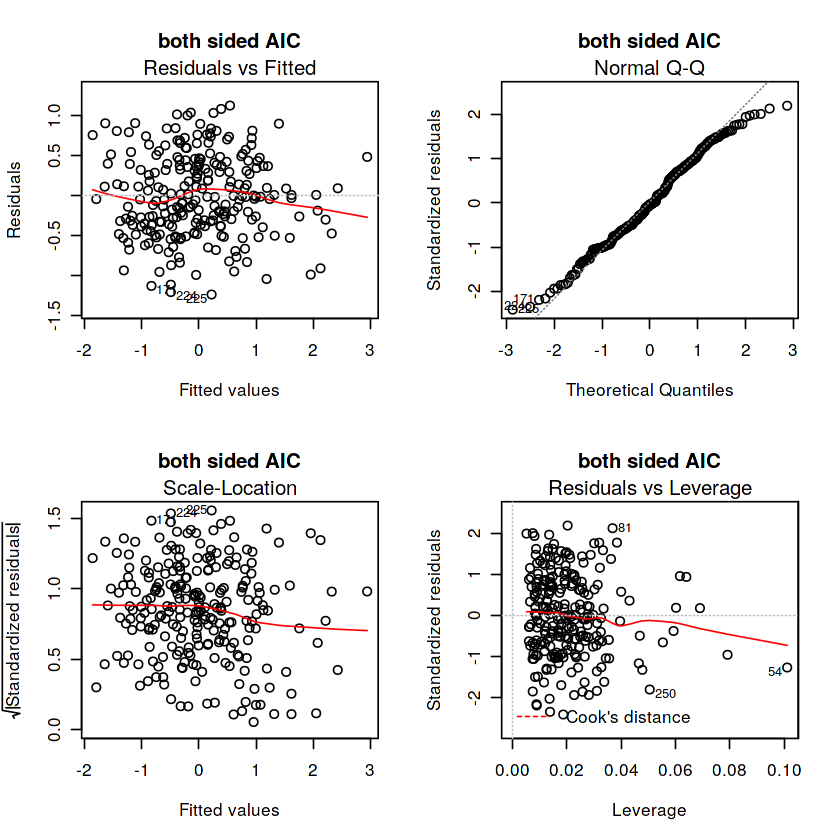

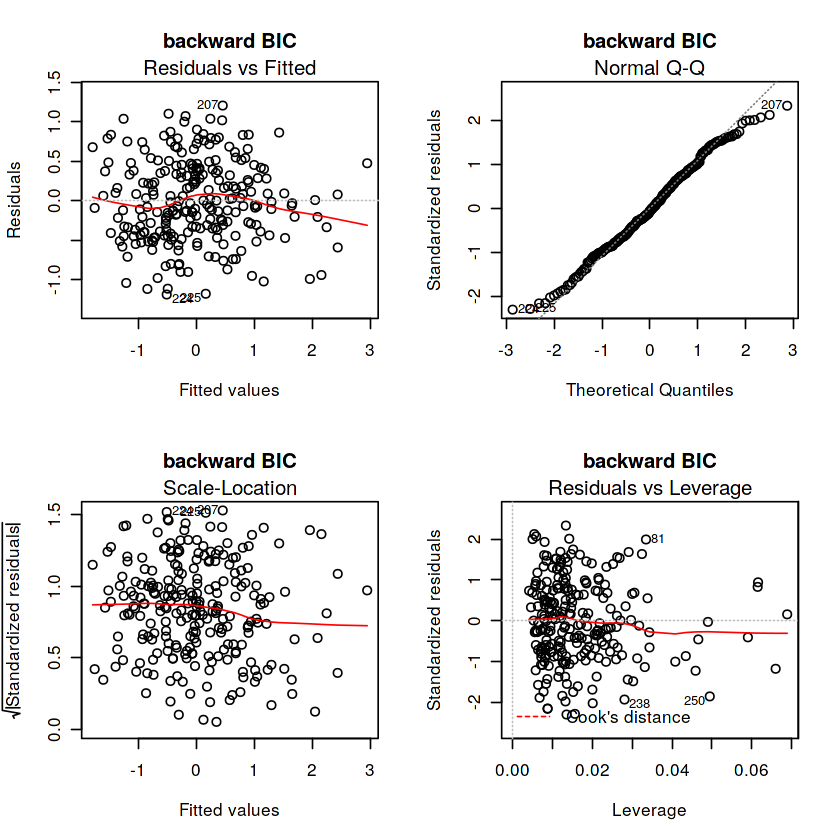

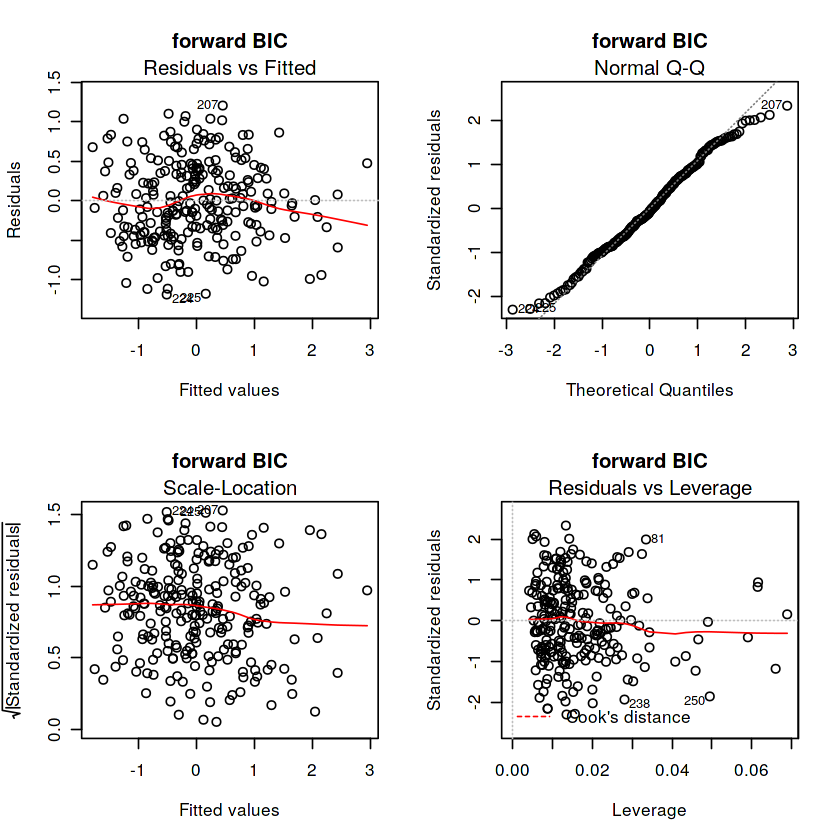

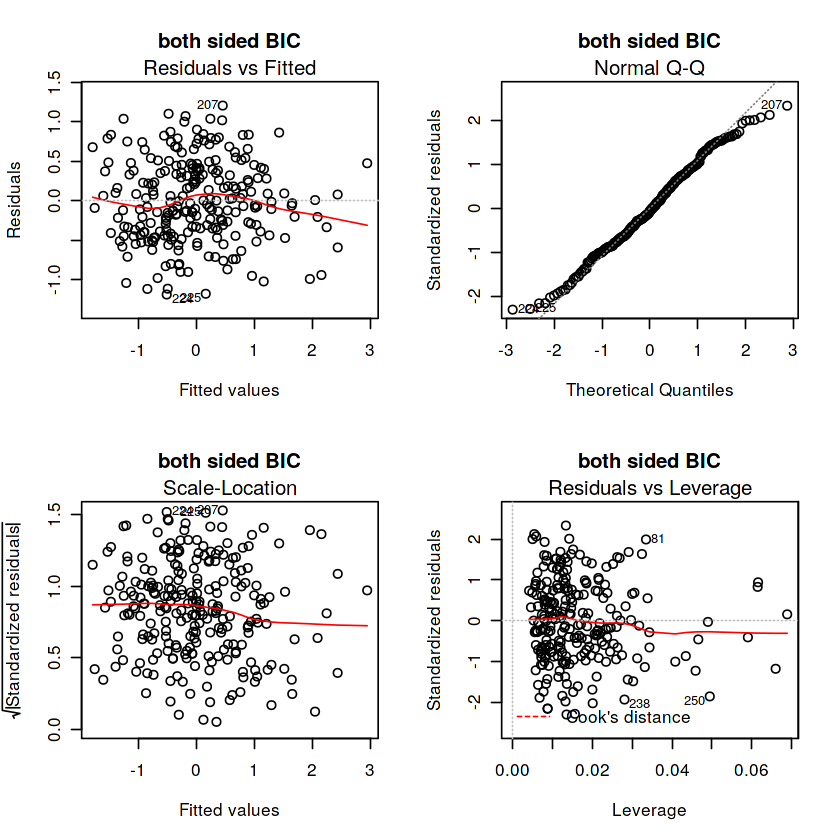

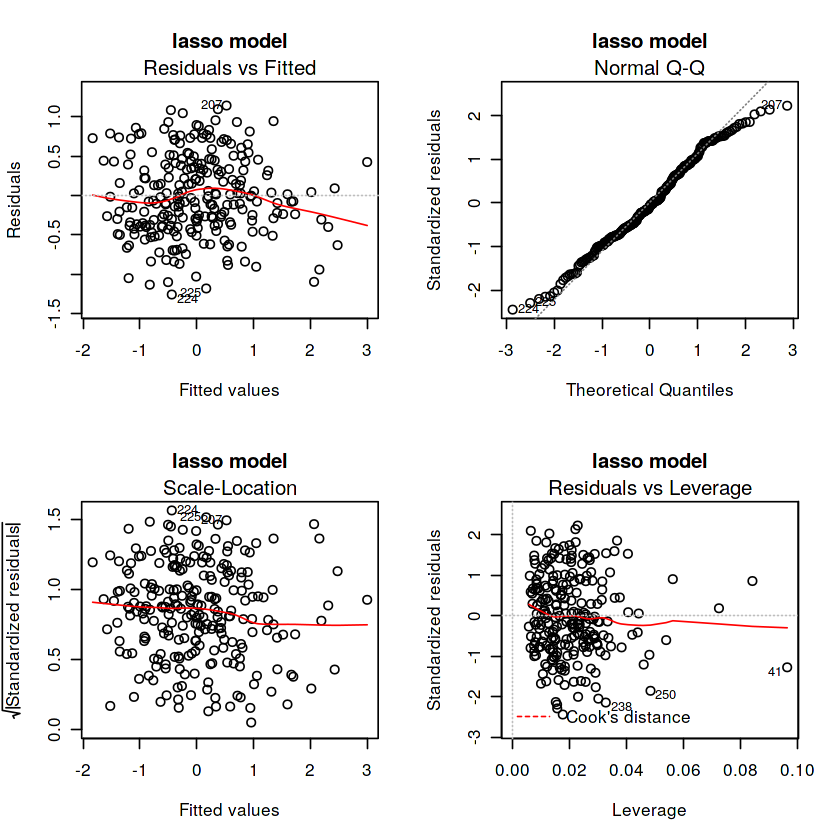

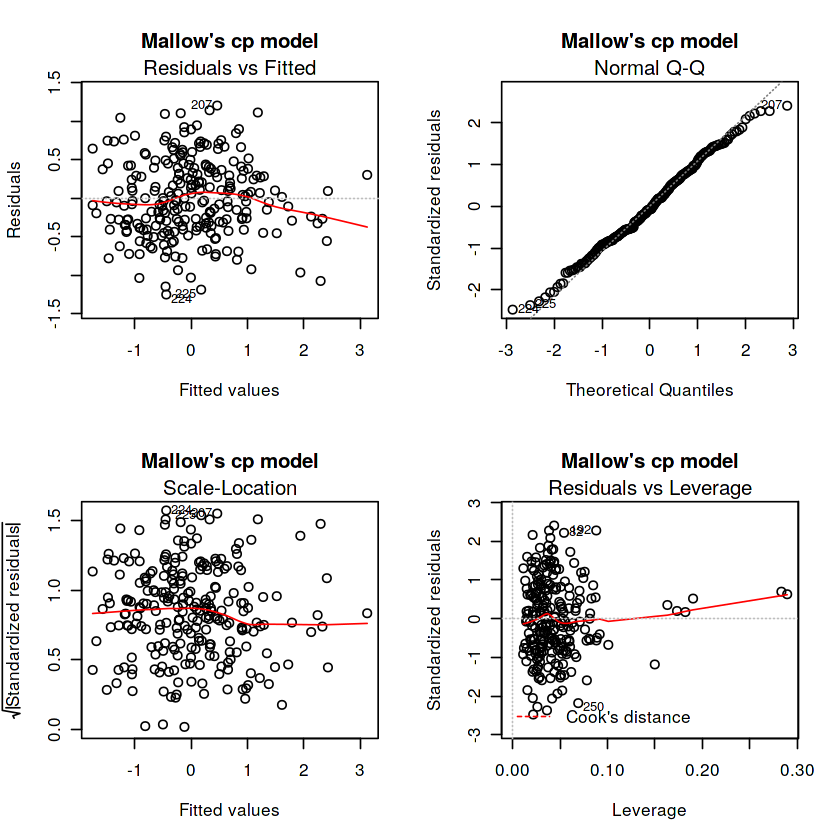

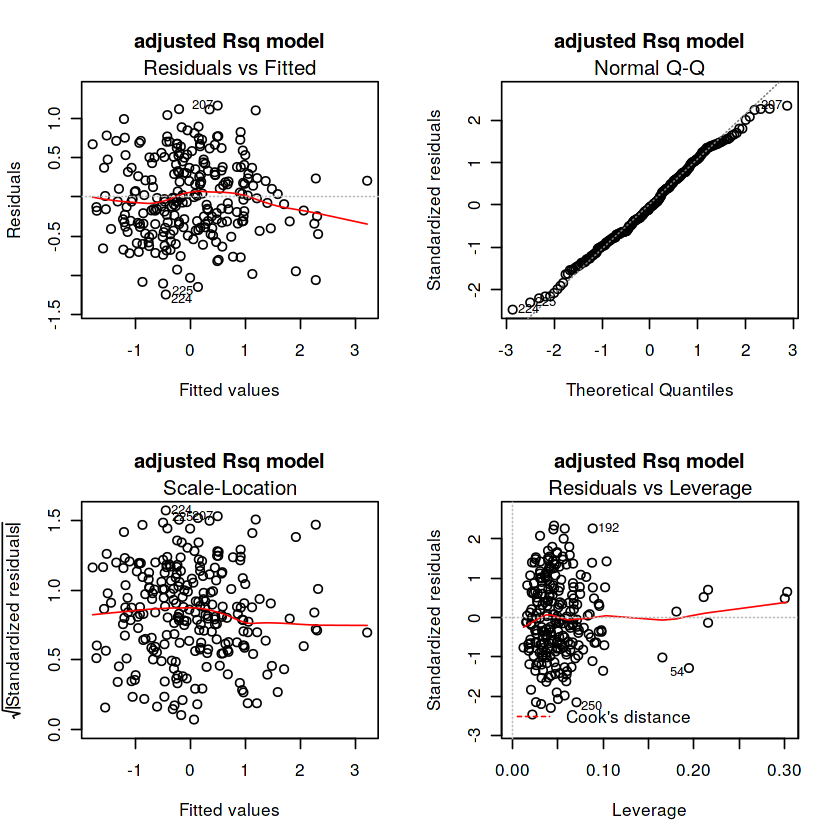

In [13]:
layout(matrix(1:4, byrow = TRUE, nrow = 2))
plot(model_AIC_b,main="backward AIC")
plot(model_AIC_f,main="forward AIC")
plot(model_AIC_t,main="both sided AIC")
plot(model_BIC_b,main="backward BIC")
plot(model_BIC_f,main="forward BIC")
plot(model_BIC_t,main="both sided BIC")
plot(model_l,main="lasso model")
plot(cp_lm,main="Mallow's cp model")
plot(adr_model,main="adjusted Rsq model")

#### Also do ANOVA table among them, model BIC forward is the best considering the F statistics and adjusted R square.

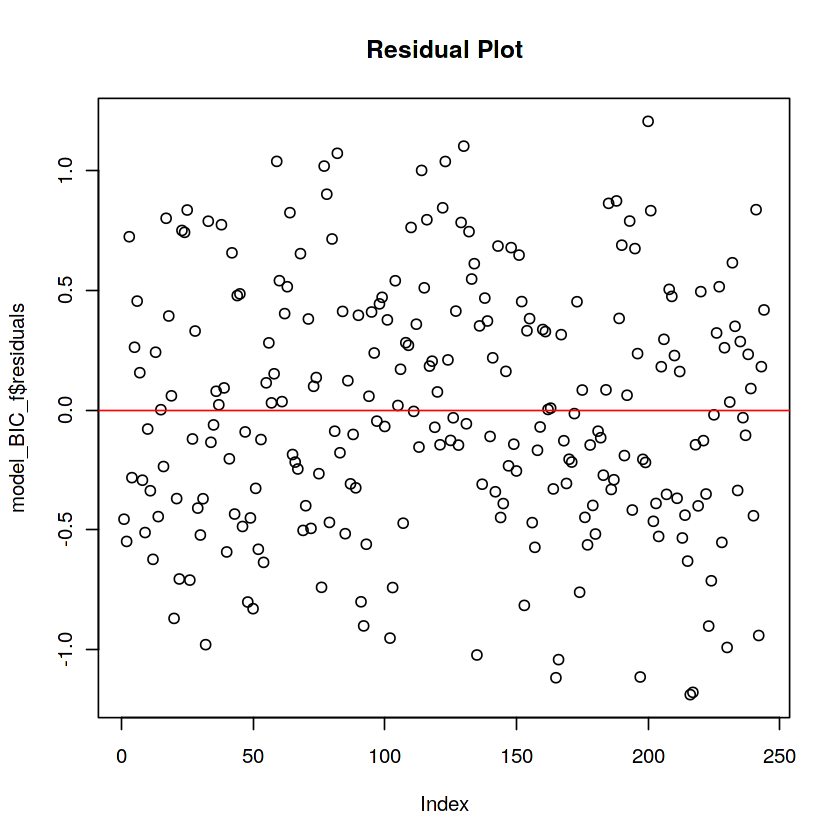

In [14]:
plot(model_BIC_f$residuals,main="Residual Plot")
abline(h=0,col="red")

### According to the model selection steps above, it seems that *abdomen, weight and wrist* are three most important predictors. By "rule of thumb" we can choose our predictors among them. Now check the possible multicolinearity betweeen abdomen, wrist and  weight. We create cleaned data that are not scaled again

In [15]:
new_data_clean = data_new[c(-39, -42, -48, -96, -76, -163, -182, -221), ]

In [16]:
cor(new_data_clean$WRIST,new_data_clean$ABDOMEN)
cor(new_data_clean$WEIGHT,new_data_clean$ABDOMEN)
cor(new_data_clean$WRIST,new_data_clean$WEIGHT)
vif(lm(BODYFAT ~ ABDOMEN + WEIGHT + WRIST, data = new_data_clean))
vif(lm(BODYFAT ~ ABDOMEN + WEIGHT, data = new_data_clean))
vif(lm(BODYFAT ~ ABDOMEN + WRIST, data = new_data_clean))

[1] 0.6030499

[1] 0.8726902

[1] 0.7268816

ABDOMEN   WEIGHT    WRIST 
4.231270 5.708738 2.138873

ABDOMEN   WEIGHT 
4.194422 4.194422

ABDOMEN   WRIST 
1.57151 1.57151

#### It seems that these predictors are correlated but can not be considered as multicollinearity.  We consider using only two variables and see the model's performence.

#### We consider using only two variables or even only one to see the model's performence-try to use only two x and check the model results

In [17]:
summary(lm(BODYFAT ~ ABDOMEN + WRIST, data = new_data_clean))
summary(lm(BODYFAT ~ ABDOMEN + WEIGHT, data = new_data_clean))


Call:
lm(formula = BODYFAT ~ ABDOMEN + WRIST, data = new_data_clean)

Residuals:
    Min      1Q  Median      3Q     Max 
-9.3973 -2.9225 -0.2025  2.9356 10.3555 

Coefficients:
             Estimate Std. Error t value Pr(>|t|)    
(Intercept) -11.19959    5.39785  -2.075   0.0391 *  
ABDOMEN       0.72574    0.03234  22.440  < 2e-16 ***
WRIST        -2.02533    0.36453  -5.556 7.29e-08 ***
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Residual standard error: 4.087 on 241 degrees of freedom
Multiple R-squared:  0.7146,	Adjusted R-squared:  0.7123 
F-statistic: 301.8 on 2 and 241 DF,  p-value: < 2.2e-16



Call:
lm(formula = BODYFAT ~ ABDOMEN + WEIGHT, data = new_data_clean)

Residuals:
    Min      1Q  Median      3Q     Max 
-10.129  -2.897  -0.116   2.880   9.816 

Coefficients:
             Estimate Std. Error t value Pr(>|t|)    
(Intercept) -42.30901    2.45220 -17.253  < 2e-16 ***
ABDOMEN       0.90497    0.05195  17.420  < 2e-16 ***
WEIGHT       -0.12520    0.01974  -6.344  1.1e-09 ***
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Residual standard error: 4.018 on 241 degrees of freedom
Multiple R-squared:  0.7241,	Adjusted R-squared:  0.7218 
F-statistic: 316.3 on 2 and 241 DF,  p-value: < 2.2e-16


#### By summary table, we can see the R-square value of "ABDOMEN and WRIST" model and ABDOMEN and WEIGHT are almost the same. Also, by VIF analysis we find the VIF of "ABDOMEN and WEIGHT" model is larger than "ABDOMEN and WRIST" model.

#### So our final model should be BODYFAT ~ ABDOMEN + WRIST because it is they are two most important predictors and it can be easily measured. Then we do model diagnostics.

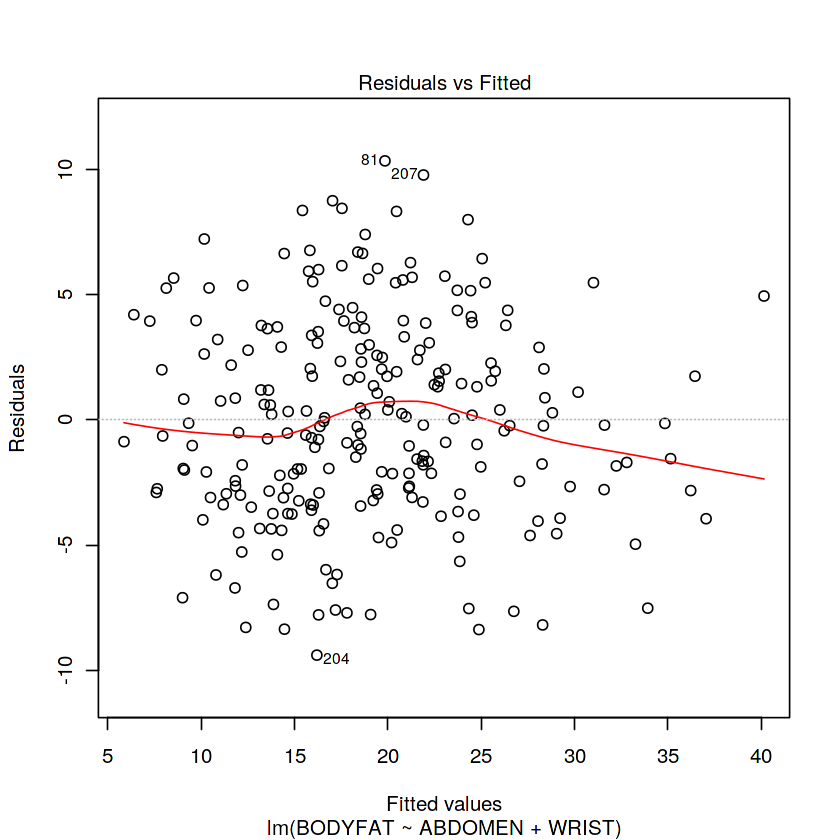

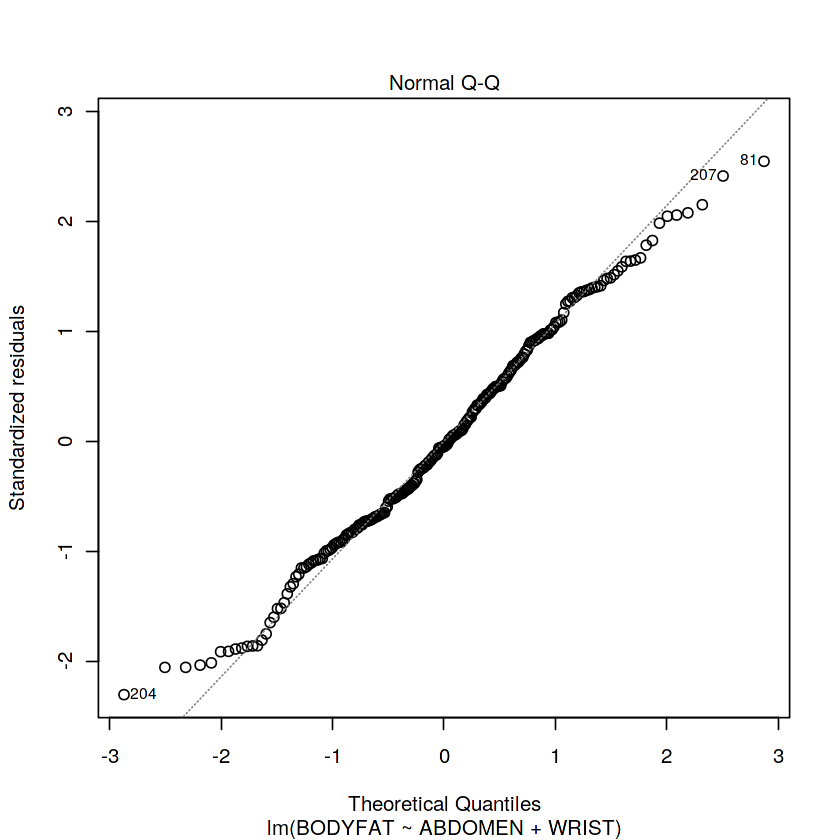

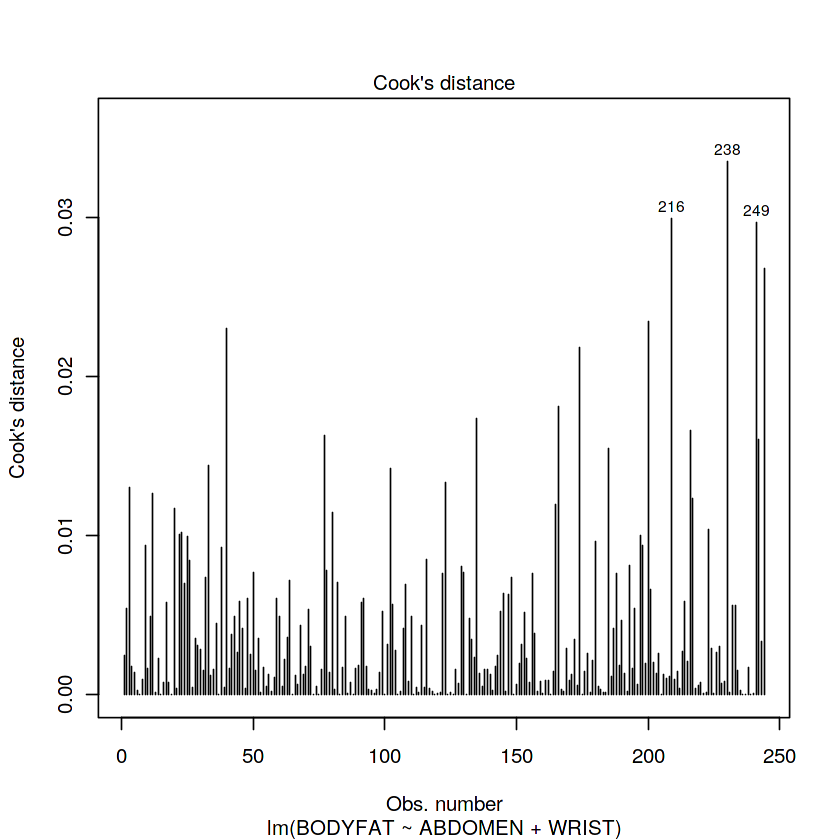

In [18]:
final_model<-lm(BODYFAT ~ ABDOMEN + WRIST, data = new_data_clean)
plot(final_model,which=1)
plot(final_model,which=2)
plot(final_model,which=4)

#### Advantages of Our Model
#### 1.Our final model is simple and straightforward. The variables included for prediction is easy to get.
#### 2.The model is robust.
#### 3.The model is accurate as the adjusted R-squared is greater than 0.6.